# Density method - $\mu$ interpolation

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw

## 1) Geometry

In [2]:
from Geometry import transformer

mesh = transformer(NCoils = 2, hmax=0.005)

Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## 2) Magnetostatic problem

In [3]:
from Solver import solveMag

nu0 = 1/(4e-7 * pi) 
a0, Kinv = solveMag(nu0, mesh)

Draw(a0, mesh, settings = {"Objects" : { "Wireframe" : False } })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 3) Objective function & adjoint problem
### a) Objective function

In [4]:
def avgSecondaryFlux(state):
    return Integrate ( state, mesh.Materials("Sp") ) - Integrate ( state, mesh.Materials("Sm") ) 


# we want to maximize the secondary flux = minimize its opposite
def objectiveFunction(state):
    return - avgSecondaryFlux(state)

print(f" {objectiveFunction(a0) = :.5e} Wb/m")

 objectiveFunction(a0) = -3.87551e-09 Wb/m


### b) Adjoint problem

In [5]:
def objectiveFunctionDD(a, aStar):
    """ Directional derivative of the objective function in the direction aStar """
    return aStar*dx("Sm")  - aStar*dx("Sp")

from Solver import solveAdjoint

p0 = solveAdjoint(Kinv, a0, objectiveFunctionDD)

Draw(p0, mesh, settings = {"Objects" : { "Wireframe" : False } })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 4) Material interpolation

Even if BESO is a ON-OFF method without intermediate materials, the computation of the derivative still depends on the derivative of the interpolation at $\rho = 0$ and $\rho = 1$.

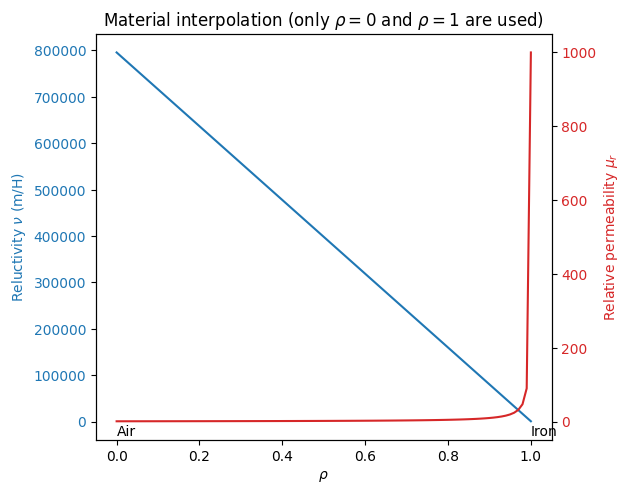

In [6]:
q = 0  # can be changed to add penalization

nu0 = 1/(4e-7*pi)
nu_f = nu0/1000

flagInterp = "nuLinear" 

if flagInterp == "muLinear":         # mu "interpolation" -> unstable
    def rho2nu(rho):
        """ Returns the reluctivity equivalent to a RAMP interpolation of permeability
        q = 0  => linear interpolation of permeability """
        return 1 / ( 1/nu0 + (1/nu_f-1/nu0)*rho/(q-q*rho+1) )  

    def dnu_drho(rho):
        """ Derivative of rho2nu """
        return -(nu0*nu_f*(nu0 - nu_f)*(q + 1))/(nu_f + nu_f*q + nu0*rho - nu_f*rho - nu_f*q*rho)**2

elif flagInterp == "nuLinear":       # nu "interpolation"  ->  stable
    def rho2nu(rho):
        """ Returns RAMP interpolation of reluctivity
        q = 0  => linear interpolation of reluctivity """
        return  nu0 + (nu_f-nu0)*rho/(q-q*rho+1)  

    def dnu_drho(rho):
        """ Derivative of rho2nu """
        return (nu_f-nu0)*(q+1)/(q-q*rho+1)**2

elif flagInterp == "topologicalDerivative":  # theoretical topological derivative -> unstable
    def rho2nu(rho):
        """ Consistent interpolation with topological derivative
         see http://dx.doi.org/10.1109/ICEM51905.2022.9910654"""
        return nu0 + (nu_f - nu0) * (2*nu0/(nu0+nu_f) * rho - (nu0-nu_f)/(nu0+nu_f) * rho**2)
    
    def dnu_drho(rho):
        """ derivative of consistent relaxation that is d0 in 0 and d1 in 1  """
        return (nu_f - nu0) * (2*(nu0 - nu0*rho + nu_f*rho))/(nu0 + nu_f)
    
######## Plot
import matplotlib.pyplot as plt
import numpy as np

r = np.linspace(0,1,100)
fig, ax1 = plt.subplots(); color = 'tab:blue'
ax1.plot(r,rho2nu(r), color = color); ax1.text(0,-3e4,"Air"); ax1.text(1,-3e4,"Iron")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('$\\rho$'); ax1.set_ylabel("Reluctivity $\\nu$ (m/H)", color = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Relative permeability $\\mu_r$", color=color)
ax2.plot(r, nu0/rho2nu(r), color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title("Material interpolation (only $\\rho = 0$ and $\\rho = 1$ are used)")
plt.show()
########

## 5) Gradient of objective function w.r.t $\rho$

In [7]:
from Solver import Curl

def dobjectiveFunction_drho(rho, state, adjoint):
    return - Curl(adjoint) * (dnu_drho(rho) * Curl(state))

Draw(dobjectiveFunction_drho(0, a0, p0), mesh, settings = {"Objects" : { "Wireframe" : False } })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 6) Volume

In [8]:
V0 = Integrate(CF((1)), mesh) # volume of Omega

def volume(rho):
    return Integrate(rho, mesh) / V0

def dvolume_drho(rho):
    """ Scalar field representing the linear form obtained by the directional derivative of the volume 
    The directionnal derivative in the gamma direction reads < dvolume_drho, gamma > """
    return CF((1)) / V0

## 7) Optimization - BESO update

In [9]:
from copy import copy

mask = GridFunction(L2(mesh))
mask.Set(mesh.MaterialCF({"Omega_c" : 1}))
maskOmega_c = mask.vec.FV().NumPy()[:]

### a) Optimization parameters

In [10]:
## Initialization

rho0 = 0;         # Initial value of rho (homogeneous)
mass_target = 0.1   # Target volume
rho = GridFunction(L2(mesh))
rho.Set(mesh.MaterialCF({ "Omega_c" : rho0}, default=0))


### b) BESO update

In [11]:
eVol = Integrate(CF(1), mesh, element_wise=True ).NumPy()[:] / V0

def BESO_update(rho, 
                integralError = 0,
                Kp = 0,
                Ki = 1,
                rho2nu = rho2nu,
                f = objectiveFunction,                                # f(u)
                df_du = objectiveFunctionDD,                          # df_du(u, uStar)
                df_drho = dobjectiveFunction_drho,
                error = lambda rho : 0.1 - volume(rho),
                maskOptimDomain = maskOmega_c,                        # mask of the optimization domain
                elementVol = eVol,
                scene = None):
    
    mesh = rho.space.mesh

    if scene is not None : scene.Redraw(rho, mesh, min=0, max = 1, settings = {"Objects" : { "Wireframe" : False } })

    # 1) Solve physical state
    u, Kinv = solveMag(rho2nu(rho), mesh)
    obj = f(u)

    # 2) Solve adjoint
    p = solveAdjoint(Kinv, u, df_du)

    # 3) Descent direction
    descent = GridFunction(rho.space)
    descent.Set(- df_drho(rho, u, p))

    # 4) "PI controller" output (desired volume at the end of the iteration)
    epsilon = error(rho)
    integralError = min(max((-Kp*epsilon)/Ki, integralError + epsilon ), (1 - Kp*epsilon)/Ki)
    targetVolume = Kp * epsilon + Ki * integralError # integral controller with simple anti windup

    # 5) BESO-like update
    descentNumpy = descent.vec.FV().NumPy()[:]
    descentNumpy[maskOptimDomain == 0] = - np.inf # putting iron in coils is forbidden
    sortedIds = np.argsort(descentNumpy)

    volumeFunction = np.cumsum(elementVol[sortedIds])
    
    criticalElementIndex = descentNumpy[sortedIds][len(sortedIds)-1-np.argmin(np.abs(volumeFunction-targetVolume))]
    rho.vec.FV().NumPy()[sortedIds] = ( criticalElementIndex < descentNumpy[sortedIds] )

    return rho, obj, epsilon, integralError

### c) Optimization loop

In [12]:
# Initial geometry
rho  = GridFunction(L2(mesh))
rho.Set(0)

# Parameters
N_max = 100
tolError = 1e-4

# BESO-like parameters
Ki = 0.1
Kp = 0.1
integralError = 0 

# Loop
scene = Draw(rho, mesh, settings = {"Objects" : { "Wireframe" : False } })
rhoList = [copy(rho)]
objectiveList = []
constraintList = []
for n in range(N_max):
    rho, obj, error, integralError = BESO_update(rho, integralError = integralError, Kp = Kp, Ki = Ki, scene = scene)
    
    rhoList.append(copy(rho))
    objectiveList.append(obj)
    constraintList.append(error)
    print(f"{n = } | f = {obj:.6e} | g = {-error:.3e}")
    if abs(error) < tolError:
        break


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

n = 0 | f = -3.875507e-09 | g = -1.000e-01
n = 1 | f = -3.975895e-08 | g = -7.955e-02
n = 2 | f = -7.271230e-08 | g = -7.377e-02
n = 3 | f = -1.741250e-07 | g = -6.709e-02
n = 4 | f = -1.435112e-05 | g = -6.094e-02
n = 5 | f = -1.609577e-05 | g = -5.493e-02
n = 6 | f = -1.718435e-05 | g = -5.012e-02
n = 7 | f = -1.799023e-05 | g = -4.566e-02
n = 8 | f = -1.881925e-05 | g = -4.138e-02
n = 9 | f = -1.949894e-05 | g = -3.748e-02
n = 10 | f = -2.027351e-05 | g = -3.406e-02
n = 11 | f = -2.093384e-05 | g = -3.084e-02
n = 12 | f = -2.153697e-05 | g = -2.795e-02
n = 13 | f = -2.190327e-05 | g = -2.557e-02
n = 14 | f = -2.237219e-05 | g = -2.319e-02
n = 15 | f = -2.278277e-05 | g = -2.109e-02
n = 16 | f = -2.301240e-05 | g = -1.907e-02
n = 17 | f = -2.331052e-05 | g = -1.727e-02
n = 18 | f = -2.356111e-05 | g = -1.559e-02
n = 19 | f = -2.388578e-05 | g = -1.407e-02
n = 20 | f = -2.405361e-05 | g = -1.275e-02
n = 21 | f = -2.423085e-05 | g = -1.158e-02
n = 22 | f = -2.441896e-05 | g = -1.050e-0

## 8) Analysis of the results

### a) Quantities of interest

In [13]:
u, _ = solveMag(rho2nu(rho),mesh)
print(f"Results BESO : flux = {avgSecondaryFlux(u) : .5e} | vol = {volume(rho)*100 : .3f} % | iterations = {n}")

Results BESO : flux =  2.54854e-05 | vol =  9.993 % | iterations = 71


### b) Evolution of the objective function and constraint

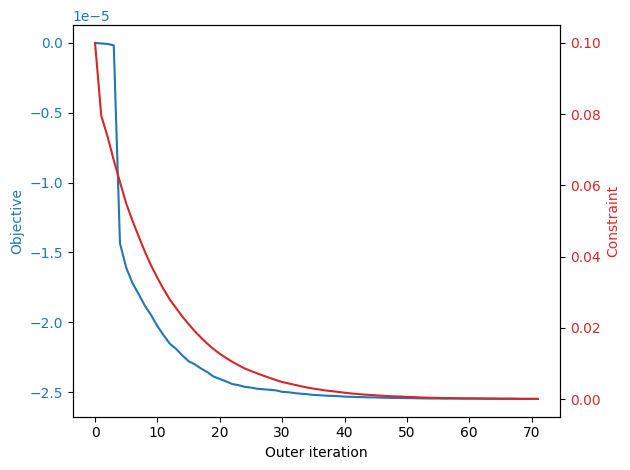

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(); color = 'tab:blue'
ax1.plot(objectiveList, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Outer iteration'); ax1.set_ylabel("Objective", color = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Constraint", color=color)
ax2.plot(constraintList, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()